In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import random
import pandas as pd
import glob
import fnmatch
from linfit import linfit
import matplotlib.pyplot as plt
import specmatchemp.library
import specmatchemp.plots as smplot
from scipy.integrate import trapz
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import CustomJS, Button
from bokeh.layouts import row, column



#-------------------------------
#FFD
#-------------------------------

def ED(start,stop,time,flux_model,flux_gap, error):
    
    '''
    Returns the equivalend duratio of a flare event,
    found within indices [start, stop],
    calculated as the area under the residual (flux_gap-flux_model)
    Returns also the error on ED following (Davenport 2016)
    
    Parameters:
    --------------
    start - start time index of a flare event
    stop - end time index of a flare event
    time - time array
    flux_model - model quiescent flux 
    flux_gap - long-term trend removed raw light curve
    error - rolling std error to raw flux
    
    Returns:
    --------------
    ed - equivalent duration in seconds
    ederr - uncertainty in seconds
    '''
    
    start, stop = int(start),int(stop)
    time = np.asarray(time)[start:stop+1]
    model = np.asarray(flux_model)[start:stop+1]
    flux = np.asarray(flux_gap)[start:stop+1]
    error = np.asarray(error)[start:stop+1]
    residual = flux - model
    ed = trapz(residual/model,time*60.*60.*24.)
    #measure error on ED
    
    flare_chisq = chisq(flux, error, model)
    ederr = np.sqrt(ed**2 / (stop-start) / flare_chisq)
    return ed, ederr, flare_chisq

def chisq(data, error, model):
    '''
    Compute the normalized chi square statistic:
    chisq =  1 / N * SUM(i) ( (data(i) - model(i))/error(i) )^2
    '''
    return np.sum( ((data - model) / error)**2.0 ) / np.size(data)


def import_flares(cluster, test, oid):
    
    objectid = str(oid)
    loc = '/home/ekaterina/Documents/appaloosa/stars_shortlist/{}/results/{}'.format(cluster,test)
#    myloc = loc + '_my_flares.txt'
#     try:
#         myflares = pd.read_csv(myloc, names= ['start','stop','istart','istop','comment'])
#     except OSError:
#         myflares = []

    appaflares = pd.read_csv('{}/{}_flux.csv'.format(loc,oid))#, names= ['time','flux_gap','error','flux_model'])
    appaids = pd.read_csv('{}/{}_flares.csv'.format(loc,oid))#, names= ['istart','istop'])

    return appaflares, appaids

def write_flares(forf,cluster, test, EPIC, typ='flares'):
    
    '''
    Writes a data frame with flares or flux 
    for a certain light curve with EPIC ID from a cluster
    analysed during a certain test.
    
    Parameter:
    ------------
    
    Returns:
    ------------
    '''
    
    loc = '/home/ekaterina/Documents/appaloosa/stars_shortlist/{}/results/{}'.format(cluster,test)
    if typ == 'flares':
        forf.to_csv('{}/{}_flares.csv'.format(loc,EPIC))
    elif typ == 'flux':
        forf.to_csv('{}/{}_flux.csv'.format(loc,EPIC))
    return 



def cum_hist(flares, flux, L_quiet,bins=5):
    ED_=[]
    s_s = flares[['istart_no_sys_no_thruster','istop_no_sys_no_thruster']]
    s_s = s_s.dropna()
    for i,row in s_s.iterrows():
        #print(row['istart'])
        #ed = ED(row['istart'],row['istop'],flux.time,flux.flux_model,flux.flux_gap)
        ed, ederr = ED(row['istart_no_sys_no_thruster'],
                       row['istop_no_sys_no_thruster'],
                       flux.time,flux.flux_model,flux.flux_gap)
        
        if (ed != 'nan') & (ed >0):
            ED_.append(np.log10(ed*24.*60.*60.*L_quiet))
    
    #print(ED_)
    #ED_ = np.asarray(ED_)
    #ED_ = ED_.dropna()
    hist, edges=np.histogram(ED_, bins=bins)

    hist = np.flip(np.cumsum(np.flip(hist,axis=0)),axis=0)

    return hist, edges


DM = lambda x: 5.*np.log10(float(x))-5. 

def color_outlier_red(val,outliers):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    if outliers.empty: outliers=[]
    color=[]
    for id_ in val:
        if id_ in list(outliers):
            color.append('red')
        else:
            color.append('black')
    #color = ['red' if val in outliers else 'black'
    return color



def energy(oid_list, cluster, test, specs,Tmin, Tmax):
    clusterenergy, clusterenergy_err, clustered, clusterederr, Teff = [], [], [], [], []
    
    for oid in oid_list:
        flux, flares = import_flares(cluster, test, oid)
        L_quiet = specs['L_quiet'].loc[oid]
        L_quiet_err = specs['L_quiet_err'].loc[oid]
        tmyed, tenergy, tenergy_err = [],[],[]
        if flares.empty:
             continue
        else:
            s_s = flares[['istart_no_sys_no_thruster','istop_no_sys_no_thruster']].dropna()
            teff =  specs['T'].loc[oid]
            for i,row in s_s.iterrows():
                ed, ederr, chi2 = ED(row['istart_no_sys_no_thruster'],
                               row['istop_no_sys_no_thruster'],
                               flux.time,flux.flux_model,flux.flux_gap, flux.error)
                energy_err = energyerr(ed, ederr, L_quiet, L_quiet_err)

                if (ed != 'nan') & (ed > 0):
                    clusterenergy.append(ed*L_quiet)
                    clusterenergy_err.append(energy_err)
                    tenergy.append(ed*L_quiet)
                    tenergy_err.append(energy_err)
                    tmyed.append(ed)
                    clustered.append(ed)
                    clusterederr.append(ederr)
                    Teff.append(teff)
                else:
                    clusterenergy.append(np.nan)
                    clusterenergy_err.append(np.nan)
                    tenergy.append(np.nan)
                    tenergy_err.append(np.nan)
                    tmyed.append(np.nan)
                    clustered.append(np.nan)
                    clusterederr.append(np.nan)
                    Teff.append(np.nan)
        flares['myed'] = tmyed
        flares['myenerg'] = tenergy
        flares['myenerg_err'] = tenergy_err
        filtered = fnmatch.filter(flares.columns.values, 'Unnamed:*')
        flares = flares.drop(filtered,axis=1)

        write_flares(flares, cluster, test, oid, typ='flares') 
    c = pd.DataFrame({'clusterenergy':clusterenergy,
                      'clusterenergy_err':clusterenergy_err,
                      'clustered':clustered,
                      'clusterederr':clusterederr,
                      'Teff':Teff,
                      'stars_in_bin':len(oid_list),
                      'Tmin':Tmin,'Tmax':Tmax})
    c['rel_energ_err']=c.clusterenergy_err/c.clusterenergy
#     loc = '/home/ekaterina/Documents/appaloosa/stars_shortlist/{}/results/{}/clusterenergies.csv'.format(cluster,test)
#     if glob.glob(loc)==[]:
#         c.to_csv(loc)
#     else:
#         c_arch = pd.read_csv(loc,usecols=['clusterenergy','clusterenergy_err','clustered',
#                                      'clusterederr','Teff','stars_in_bin','Tmin','Tmax'])
#         c = c_arch.append(c)
#         c.to_csv(loc)
    return c

def energyerr(ed, ederr, L_quiet, L_quiet_err):
    #np.sqrt((ed * L_quiet_err)**2 + (ederr * L_quiet)**2) 
    return (ed * L_quiet_err) + (ederr * L_quiet)

def FFD(oid, cluster, test, specs,color='red'):
    flux, flares = import_flares(cluster, test, oid)
    T = specs['T'].loc[oid]
    L_quiet = specs['L_quiet'].loc[oid]
    histAppa, edgesAppa = cum_hist(flares, flux, L_quiet,bins=5)
    binmids=[(x+edgesAppa[i])/2. for i,x in enumerate(edgesAppa[1:])]
    return plt.plot(binmids[1:],np.log10(histAppa[1:]),color=color,alpha=0.8,label='EPIC {}, T={}K'.format(oid,T))




## Load parameters and calculate quiescent luminosity, assign spectral class and  if not already

In [6]:
cluster_dict = {'M67':['M67','M67', 15, 4.0, 850],
                #'Ruprecht_147':['Ruprecht 147','Ruprecht_147', 30, 2.5, 300.],
                'M44':['M44','M44', 47, 0.73, 181.5],
                #'M45':['M45','M45',55.,0.12,120.],
                'NGC_1647':['NGC 1647','NGC_1647',0.,0.145,550.],
                'Pleiades':['Pleiades','Pleiades',0.,0.120,136.]
               }

cluster ='M67'
basics = cluster_dict[cluster]
test = 'run_09'
dm = DM(basics[4])
global dm
l = '/home/ekaterina/Documents/appaloosa/stars_shortlist/{0}/{0}_parameter.csv'.format(cluster)

print(glob.glob(l))
if glob.glob(l) != []:
    specs = pd.read_csv(l, index_col='EPIC')
else:
    print('Go back to step 6.')
    
specs[['T','T_err','L_quiet','L_quiet_err']].sort_values(by='T').head()

['/home/ekaterina/Documents/appaloosa/stars_shortlist/M67/M67_parameter.csv']


,T,T_err,L_quiet,L_quiet_err
EPIC,,,,
211415591,4070.0,117.898261,6.020849e+30,2.155680e+30
211397955,4620.0,210.000000,1.339399e+31,5.700978e+30
211399458,4830.0,210.000000,1.922492e+31,7.876362e+30
211394185,4830.0,210.000000,1.922492e+31,7.876362e+30
211391621,4830.0,210.000000,1.922492e+31,7.876362e+30


In [7]:
flarelist = pd.read_csv('/home/ekaterina/Documents/appaloosa/stars_shortlist/{0}/results/{1}/{0}_{1}_flarelist.txt'.format(cluster,test),
    delimiter='\t')
flarelist = flarelist[['Object ID ',' Number of Flares ']]
flarelist = flarelist.rename(index=str, columns= {'Object ID ':'EPIC',' Number of Flares ':'counts'})
flarelist = flarelist.set_index('EPIC')
#specs=specs.drop('counts', axis=1)
specs = specs.join(flarelist, how='left')
specs.counts.head()

EPIC
211392354    2
211392234    2
211396893    1
211389537    2
211396493    0
Name: counts, dtype: int64

(37, 1) (155, 61)
(37, 1) (155, 61)
(37, 1) (155, 61)
(37, 1) (155, 61)


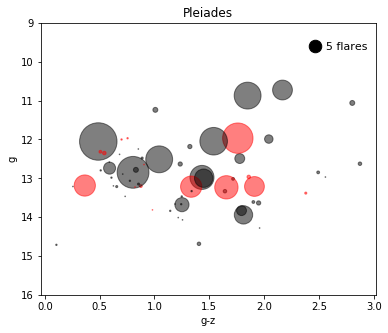

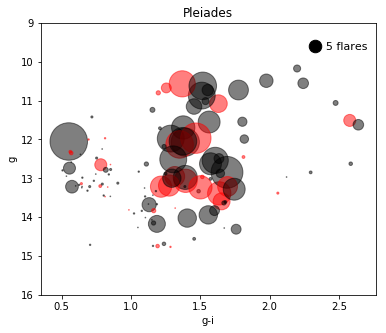

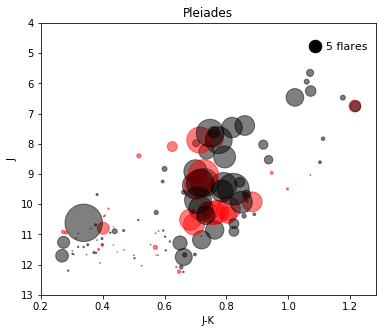

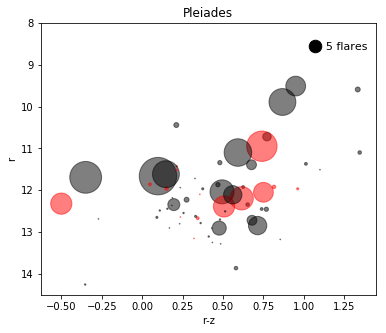

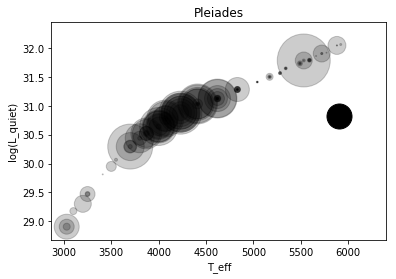

In [277]:
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle

# build a rectangle in axes coords
left, width = 0.35, .5
bottom, height = 0.4, .5
right = left + width
top = bottom + height
# ax = plt.gca()
# p = plt.Rectangle((left, bottom), width, height,
#               fill=False,
#               )



# ax.text(left, bottom, 'left top',
#         horizontalalignment='left',
#         verticalalignment='top',
#         transform=ax.transAxes)


def Teff_count(specs,cluster):
    specs['logL'] = np.log10(specs.L_quiet)
    
    plot = specs.plot(x='T',y='logL',
                      kind = 'scatter', 
                      color='black',
                      s=list(specs['counts']**2),
                      marker='o',
                      alpha=0.2,
                      title = '{}'.format(cluster),)
                      #figsize=(7,7))
    plot.set_ylabel('log(L_quiet)')
    plot.set_xlabel('T_eff')
    #plot.text(6.5, 6.5cm, r'1 flare', fontsize=11)
    plt.plot(5900, 30.82, 'o', markersize=25,color='black')
    fig = plot.get_figure()
    fig.savefig('/home/ekaterina/Documents/appaloosa/stars_shortlist/share/Teff_{}_counts.jpg'.format(cluster),dpi=300)
    return

def CMD_count(specs,cluster,cid1='gmag',cid2='imag',color='g_i',ylim=(19,5),outliers=pd.Series()):
    '''
    Plots and saves CMDs for specified bands, 
    marks outliers if any are passed.
    '''
    drops = pd.read_csv('/home/ekaterina/Documents/appaloosa/stars_shortlist/Pleiades/redgiants.csv',
                       header=None, names=['EPIC'])
    print(drops.shape,specs.shape)
    #specs = specs.drop(drops.EPIC.tolist())
    #print(drops.shape,specs.shape)
    specs[color]=specs[cid1]-specs[cid2]
    plot = specs.plot(x=color,y=cid1,ylim=ylim,
                      kind = 'scatter', 
                      color=color_outlier_red(specs.index.values,drops.EPIC),
                      s=list(specs['counts']**2./2),
                      title = '{}'.format(cluster),
                      alpha=0.5,figsize=(6,5))
    
    
    plot.set_ylabel(cid1[0])
    plot.set_xlabel('{}-{}'.format(cid1[0],cid2[0]))
    plot.text(right, top, r'5 flares', transform=plot.transAxes, fontsize=11)
    plot.plot(right-.03, top+0.016, 'o', markersize=25/2,color='black', transform=plot.transAxes)

    fig = plot.get_figure()
    ax = plt.gca()
    plt.Rectangle((left, bottom), width, height,
              fill=False,
              )
    p.set_transform(ax.transAxes)
    p.set_clip_on(False)
    #ax.add_patch(p)

    fig.savefig('/home/ekaterina/Documents/appaloosa/stars_shortlist/share/CMD_{}_{}_counts.jpg'.format(cluster,color),dpi=300)
    return

CMD_count(specs,cluster,cid1='gmag',cid2='zmag',color='g_z',ylim=(16,9))
CMD_count(specs,cluster,cid1='gmag',cid2='imag',color='g_i',ylim=(16,9))
CMD_count(specs,cluster,cid1='J',cid2='K',color='J_K',ylim=(13,4))
CMD_count(specs,cluster,cid1='rmag',cid2='zmag',color='r_z',ylim=(14.5,8))#,text=(16.5))
Teff_count(specs,cluster)

In [8]:
def cum_hist_average(oid_list, cluster, test, specs, Tmin, Tmax):
    try:
        normalize = 1./len(oid_list)
        c = energy(oid_list, cluster, test, specs, Tmin, Tmax)
        c = c.dropna(how='any')
        c = c.sort_values(by='clusterenergy')

        hist = np.ones_like(c.clusterenergy)*normalize
        hist = np.flip(np.cumsum(np.flip(hist,axis=0)),axis=0)

        err = np.asarray(c.clusterenergy_err**2)
        err = np.sqrt(np.flip(np.cumsum(np.flip(err,axis=0)),axis=0))/hist
        df = pd.DataFrame({'hi':hist,
                           'energ':c.clusterenergy,
                           'err':err,
                           'hi_err':np.sqrt(hist)*normalize})

        return df
    except ZeroDivisionError:
        return pd.DataFrame

def FFD_average(specs, cluster, test, class_='K7', 
                Tmin=3000., Tmax=7000., color='red',
                subset='class',Minenerg=5e31,Maxenerg=5e37):
    if subset == 'class':
        select = np.asarray([i for sublist in [specs[specs.spec_class.str.contains(c)].index.values 
                                               for c in class_] 
                                                 for i in sublist])
        label = '{}, n={}'.format(tuple(class_),len(select))
    elif subset == 'temperature':
        select = np.asarray([i for i in specs[(specs['T']>=Tmin) & (specs['T']<=Tmax)].index.values])
        label = '{}K - {}K, n={}'.format(Tmin,Tmax,len(select))
    
    df = cum_hist_average(select, cluster, test, specs, Tmin, Tmax)
    if df.empty:
        print('Empty sequence.')
        return [np.nan,np.nan],[np.nan,np.nan], np.nan, 0, 0
    else:
        df = df[(df.energ > Minenerg) &  (df.energ < Maxenerg)]
        df = df.dropna(how='any')
        
    #No uncertainty in energy:
    hist, binmids, err, hi_err = np.asarray(df.hi), np.asarray(df.energ), np.asarray(df.err), np.asarray(df.hi_err)
    try:
        p,residuals, rank, singular_values, rcond= np.polyfit(x=np.log10(binmids),y=np.log10(hist),deg=1, full=True)
        print(p,residuals, rank, singular_values, rcond)
        plt.plot(np.log10(binmids), 
             p[0]*np.log10(np.asarray(binmids))+p[1],
             #label='Least square fit, no x-errors.',
             color=color,
             alpha=0.5)
    except TypeError:
        pass
    
    #Take into account uncertainty in energy orthogonal distance regression
    try:
        df2 = np.log10(df)
        df2 = df2.dropna(how='any') 
        df2.err = np.abs(df2.energ-df2.err)
        df2.hi_err = np.abs(df2.hi-df2.hi_err)
        df2.hi_err.iloc[-1] = df2.hi_err.iloc[-2]
        hist2, binmids2 = np.asarray(df2.hi), np.asarray(df2.energ)
        err2, hi_err2 = np.asarray(df2.err), np.asarray(df2.hi_err)

        p2, var = linfit(binmids2,hist2, err2, hi_err2)

        #standardised major axis regression?

        #Print results
        plt.plot(np.log10(binmids), 
             p2[0]*np.log10(np.asarray(binmids))+p2[1],
             color=color,
             #label='Orthogonal distance regression.'
                )
    except IndexError:
        return [np.nan,np.nan],[np.nan,np.nan], np.nan, 0, 0
    alpha = r'{:.2f}$\pm${:.2f}'.format(p2[0],var[0])
    plt.scatter(np.log10(binmids), np.log10(hist), 
#                  xerr=[np.log10(binmids)-np.log10(err),
#                        np.log10(binmids)-np.log10(err)],
#                  yerr=[np.log10(hist)-np.log10(hi_err),
#                        np.log10(hist)-np.log10(hi_err)],
#                  fmt='o',
                 label='{}, alpha={}'.format(label,alpha),
                color=color)

    return list(p2), list(var), df.energ.max(), len(select), len(df)


Empty sequence.
Empty sequence.
[-0.79826999 25.57436301] [0.02384908] 2 [1.41419888 0.00644452] 1.1102230246251565e-15
[-0.97530986 31.62022633] [0.14063647] 2 [1.41419659 0.00692916] 3.3306690738754696e-15
[-0.88132429 28.36451495] [0.19948203] 2 [1.41418778 0.00854016] 5.995204332975845e-15
[-1.00432385 32.82000392] [0.15429945] 2 [1.41419683 0.00687869] 3.774758283725532e-15
[-0.98813922 31.93103562] [0.24090087] 2 [1.41419561 0.00712548] 4.440892098500626e-15
[-0.94799985 30.67545219] [0.54903029] 2 [1.41418969 0.00821651] 9.769962616701378e-15
[-1.01620963 32.86960817] [0.86848444] 2 [1.4141915  0.00789953] 1.4210854715202004e-14


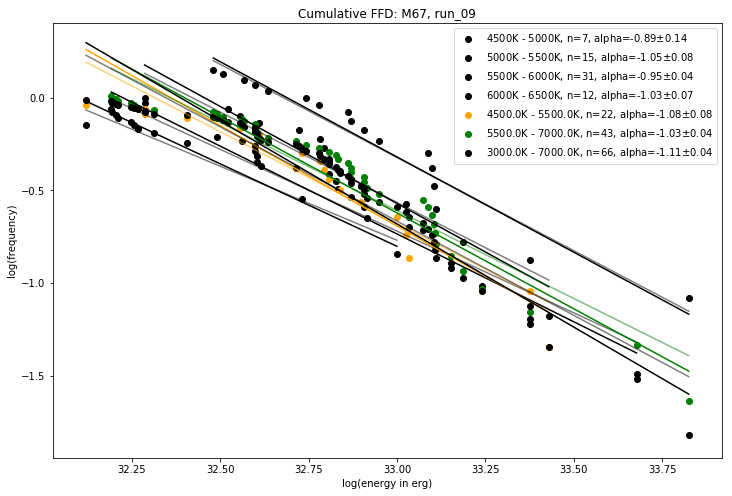

In [9]:
plt.figure(figsize=(12,8))
plt.title('Cumulative FFD: {}, {}'.format(cluster,test))
trange = [(i,i+500,'black') for i in range(3000,6500,500)]
trangeadd = [(4.5e3,5.5e3,'orange'),(5.5e3,7e3,'green'),(3e3,4.5e3,'red'),(3e3,7e3,'black')]
trange += trangeadd
header = ['Tmin','Tmax','alpha','beta','alpha_err','beta_err','minenerg','maxenerg']
results = pd.DataFrame(columns=header)
for (Tmin, Tmax, color) in trange:
    minenerg,maxenerg = 1e32, 5e36
    p, var, maxenerg, n_obj, n_flares = FFD_average(specs, cluster, test, color=color,
                                                    Tmin=Tmin,Tmax=Tmax,subset='temperature',
                                                    Minenerg=minenerg,Maxenerg=maxenerg)
    l = [[i] for i in [Tmin, Tmax, p[0], p[1], 
                       var[0], var[1], minenerg, 
                       maxenerg, n_obj, n_flares]]
    t = pd.DataFrame(dict(list(zip(header,l))))
    results = results.append(t,ignore_index=True)
    plt.legend()
plt.xlabel('log(energy in erg)')
plt.ylabel('log(frequency)')

#plt.savefig('/home/ekaterina/Documents/appaloosa/stars_shortlist/{0}/results/{1}/plots/{0}_{1}_cum_FFD.jpg'.format(cluster,test))
#plt.savefig('/home/ekaterina/Documents/appaloosa/stars_shortlist/share/{0}_{1}_cum_FFD.jpg'.format(cluster,test))
#results.to_csv('/home/ekaterina/Documents/appaloosa/stars_shortlist/share/{0}_{1}_cum_FFD.csv'.format(cluster,test))

[-0.44475569 14.62926551] [25.46687905] 2 [1.41409498 0.01831348] 1.2811973704174306e-13


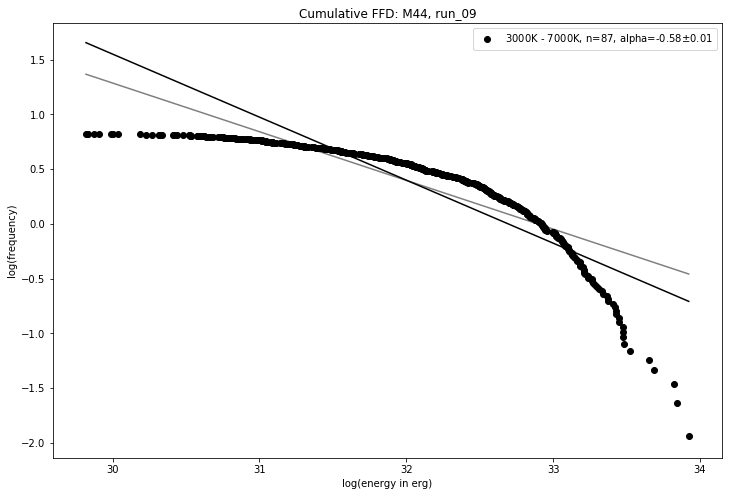

In [14]:
plt.figure(figsize=(12,8))
plt.title('Cumulative FFD: {}, {}'.format(cluster,test))
#trange = [(3e3,7e3,'black'),(4.5e3,5.5e3,'orange'),(5.5e3,7e3,'green'),(3e3,4.5e3,'red'),]
#trangeadd = [(i,i+500,'black') for i in range(3000,6500,500)]
#trange += trangeadd
trange =[(3000,7000,'black')]
header = ['Tmin','Tmax','alpha','beta','alpha_err','beta_err','minenerg','maxenerg']
results = pd.DataFrame(columns=header)
for (Tmin, Tmax, color) in trange:
    minenerg,maxenerg = 1e29, 4e38
    p, var, maxenerg, n_obj, n_flares = FFD_average(specs, cluster, test, color=color,
                                                    Tmin=Tmin,Tmax=Tmax,subset='temperature',
                                                    Minenerg=minenerg,Maxenerg=maxenerg)
    l = [[i] for i in [Tmin, Tmax, p[0], p[1], 
                       var[0], var[1], minenerg, 
                       maxenerg, n_obj, n_flares]]
    t = pd.DataFrame(dict(list(zip(header,l))))
    results = results.append(t,ignore_index=True)
    plt.legend()
plt.xlabel('log(energy in erg)')
plt.ylabel('log(frequency)')

#plt.savefig('/home/ekaterina/Documents/appaloosa/stars_shortlist/{0}/results/{1}/plots/{0}_{1}_cum_FFD.jpg'.format(cluster,test))
#plt.savefig('/home/ekaterina/Documents/appaloosa/stars_shortlist/share/{0}_{1}_cum_FFD.jpg'.format(cluster,test))
#results.to_csv('/home/ekaterina/Documents/appaloosa/stars_shortlist/share/{0}_{1}_cum_FFD.csv'.format(cluster,test))